In [ ]:
import os
import numpy as np
from load_data import *
from sklearn.model_selection import train_test_split
import torch
from torch.nn import *
from models import *
from training import *
from torch.utils.data import *
import matplotlib.pyplot as plt
import time

In [ ]:
# Set seed for random initialization
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Load data

In [ ]:
params, solutions, basis_space, basis_time, sv_space, sv_time = load_data()

# Upper and lower bound of params
upper_bounds_params = np.array([8.0, 0.3, 0.5, 0.5, 0.5, 0.0])
lower_bounds_params = np.array([4.0, 0.1, -0.1, -0.5, -0.5, -0.3])

# Params mapping to [0, 1]
params = (params - lower_bounds_params) / (upper_bounds_params - lower_bounds_params)

# Singular values

In [ ]:
def f(w):
	# return w
	# return w ** 2
	return torch.sqrt(w)

In [ ]:
sv_space_v = torch.tensor(sv_space['velocity'], dtype=torch.float32)
sv_space_v = f(sv_space_v)

sv_time_v = torch.tensor(sv_time['velocity'], dtype=torch.float32)
sv_time_v = f(sv_time_v)

sv_space_p = torch.tensor(sv_space['pressure'], dtype=torch.float32)
sv_space_p = f(sv_space_p)

sv_time_p = torch.tensor(sv_time['pressure'], dtype=torch.float32)
sv_time_p = f(sv_time_p)

sv_v = torch.reshape(sv_space_v.view(sv_space_v.shape[0], -1) * sv_time_v.view(-1, sv_time_v.shape[0]), (-1, sv_space_v.shape[0] * sv_time_v.shape[0])).squeeze()
sv_p = torch.reshape(sv_space_p.view(sv_space_p.shape[0], -1) * sv_time_p.view(-1, sv_time_p.shape[0]), (-1, sv_space_p.shape[0] * sv_time_p.shape[0])).squeeze()

sv_v = sv_v / torch.sum(sv_v)
sv_p = sv_p / torch.sum(sv_p)

# Split training and test set

In [ ]:
# Splitting train-test

split = 0.9

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(params, solutions['velocity'], test_size=1-split, random_state=0)
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(params, solutions['pressure'], test_size=1-split, random_state=0)

# Create Dataset objects for training and validation

In [ ]:
# Class for a dataset structure

class CreateDataset(Dataset):

    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(x.shape[0], -1), dtype=torch.float32)  # unique tensor for space and time

    def __getitem__(self,index):
        sample = {
            'feature': self.x[index],
            'label': self.y[index]}
        return sample

    def __len__(self):
        return len(self.x)

# Train the final models

In [ ]:
# Parameters

# Set device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Number of neurons per layer
K = 256

# Learning rate
lr = 0.01

# Number of epochs
num_epochs = 500

# K-fold
folds = 5

# Batch size
batch_size = 32

Train epoch 1: loss = 0.5570929127269321, error = 0.4103537375397152, lr = 0.0099
Train epoch 101: loss = 0.07756658050749037, error = 0.059935695942905216, lr = 0.003148091731809522
Train epoch 201: loss = 0.05203542239136166, error = 0.03555653954545657, lr = 0.001001058742614896
Train epoch 301: loss = 0.045146090421411725, error = 0.02958137893842326, lr = 0.00031832573239207976
Train epoch 401: loss = 0.04280367261833615, error = 0.027968834969732497, lr = 0.00010122410163290076


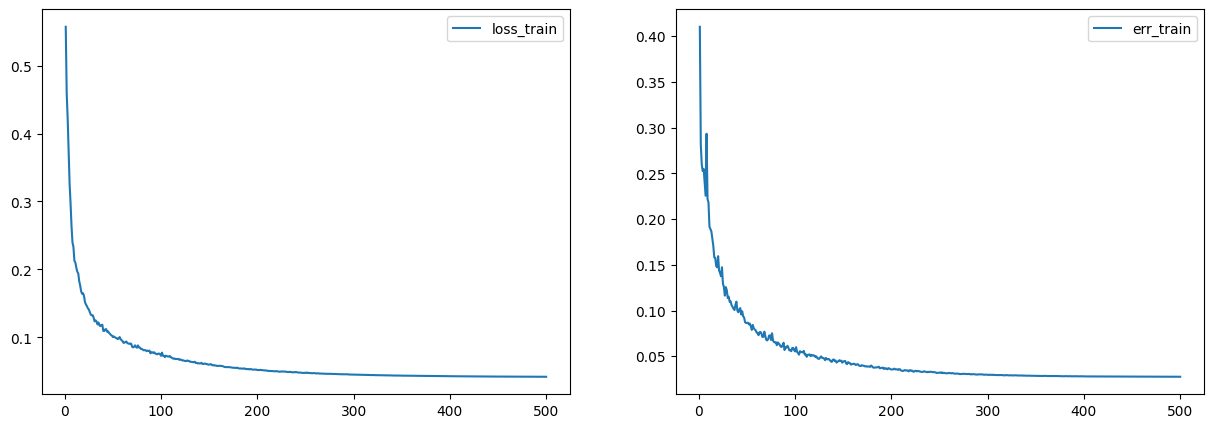

Execution time: 97s


In [ ]:
# Train the final model for velocity

train = CreateDataset(x_train_v, y_train_v)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)

model_v = PTCMapVelocity(K, 40, 37)

start = time.time()

run_training(train_gen, None, num_epochs, model_v, sv_v, lr, device)

end = time.time()
print('Execution time: {:.0f}s'.format(end - start))

Train epoch 1: loss = 174.23449666341145, error = 0.6990027046203613, lr = 0.0099
Train epoch 101: loss = 0.2853825577100118, error = 0.02649980002807246, lr = 0.003148091731809522
Train epoch 201: loss = 0.11443375865618388, error = 0.01743802848789427, lr = 0.001001058742614896
Train epoch 301: loss = 0.07644837046662967, error = 0.0143323395980729, lr = 0.00031832573239207976
Train epoch 401: loss = 0.06608371850517061, error = 0.013288658397893111, lr = 0.00010122410163290076


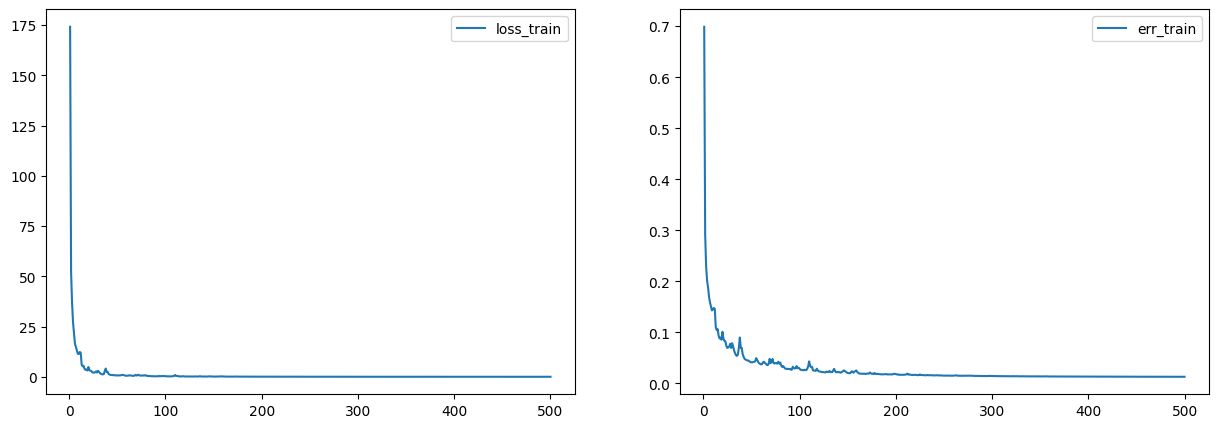

Execution time: 88s


In [ ]:
# Train the final model for pressure

train = CreateDataset(x_train_p, y_train_p)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

train_gen = DataLoader(train, batch_size=batch_size, shuffle=True)

model_p = PTCMapPressure(K, 7, 47)

start = time.time()

run_training(train_gen, None, num_epochs, model_p, sv_p, lr, device)

end = time.time()
print('Execution time: {:.0f}s'.format(end - start))

In [ ]:
# Creating pressure and velocity test datasets

test_v = CreateDataset(x_test_v, y_test_v)
test_p = CreateDataset(x_test_p, y_test_p)

In [ ]:
# Test data generators

test_v_gen = DataLoader(test_v, batch_size=len(test_v))
test_p_gen = DataLoader(test_p, batch_size=len(test_p))

In [ ]:
# Compute test error

test_error_v, predictions_v = compute_error(model_v, test_v_gen, device)
print('Velocity test error: {:.2f}%'.format(test_error_v * 100))
test_error_p, predictions_p = compute_error(model_p, test_p_gen, device)
print('Pressure test error: {:.2f}%'.format(test_error_p * 100))

Velocity test error: 6.32%
